# Hello
Hi, O'Reilly Media team! I genuinely enjoyed working through this project, and I'm thoroughly
eager to help unravel data using state-of-the art ML + optimization techniques.

Here's an outline of my Python script:
    1. Cleaning dataset
    2. Visualizing dataset
    3. Cross Validation among 3 ML classifiers
    4. Model Selection
    5. Predicting probability of ad clicked

Kindly,
Kitu Komya

# 1. Cleaning dataset
Goal is to prepare dataset for ML classifier by factorizing variables and expanding the date-time variable.


In [1]:
import pandas as pd

In [7]:
# reading in data
import os

os.chdir('/Users/Mac/Downloads/p13-takehome-ml')
sampled_test = pd.read_csv("sampled_test.csv", header = None)
sampled_training = pd.read_csv("sampled_training.csv", header = None)

In [8]:
# rename headers
sampled_training.columns = ['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id',
                            'site_domain', 'site_category', 'app_id', 'app_domain',
                            'app_category', 'device_id', 'device_ip',
                            'device_model', 'device_type', 'device_conn_type', 
                            'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

sampled_test.columns = ['id', 'hour', 'C1', 'banner_pos', 'site_id',
                            'site_domain', 'site_category', 'app_id', 'app_domain',
                            'app_category', 'device_id', 'device_ip',
                            'device_model', 'device_type', 'device_conn_type', 
                            'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

In [9]:
# loop through both datasets to simplify data cleaning
datasets = [sampled_training, sampled_test]

for sets in datasets:
    # extract day and hour by first reassigning to datetime variable
    sets['hour'] = pd.to_datetime(sets['hour'], format = '%y%m%d%H')
    sets['real_hour'] = sets['hour'].dt.hour
    sets['weekday'] = sets['hour'].dt.day_name()
    del sets['hour']

    # encode variables to category by refactorizing to a distinct number
    col_names = list(sets) # create list of column names
    col_names.remove('id') # keep id unchanged
    for col in col_names: # loop through columns to change variable type
        sets[col] = pd.factorize(sets[col])[0]
    
    # ensure all data types are in good form
    print(sets.dtypes)

id                  uint64
click                int64
C1                   int64
banner_pos           int64
site_id              int64
site_domain          int64
site_category        int64
app_id               int64
app_domain           int64
app_category         int64
device_id            int64
device_ip            int64
device_model         int64
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
real_hour            int64
weekday              int64
dtype: object
id                  uint64
C1                   int64
banner_pos           int64
site_id              int64
site_domain          int64
site_category        int64
app_id               int64
app_domain           int64
app_category         int64
device_id            int64
device_ip            int64
device_model  

In [10]:
# delete unnecessary data  
del datasets, sets

# 2. Visualizing dataset
Goal is to understand what our data looks like and to glean some intuition on how the classifier may work.


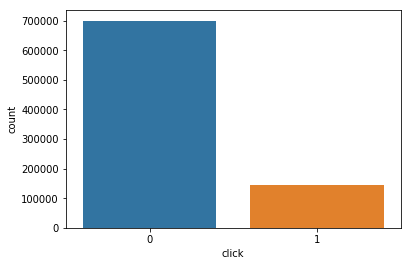

In [13]:
# explore click-rate
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x = "click", data = sampled_training)
plt.show()

Ads are not clicked on most of the time! (prior probability)

In [12]:
# look into proportions
sampled_training['click'].value_counts()/len(sampled_training)

0    0.829729
1    0.170271
Name: click, dtype: float64

An ad is clicked on only 17% of the time. We should use f1-score instead of accuracy to measure success since imbalanced classes are present.

# 3. Cross Validation
Goal is to use cross-validation to quantify the f1-score of each ML classifier in order to select one.

In [14]:
# import models
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [15]:
# create training data without id or predicting variable
train_me = sampled_training.drop(['id', 'click'], axis = 1)

In [16]:
# choose models whose assumptions are met by our (transformed) categorical + numerical dataset
model_list = []
model_list.append(("Multinomial Naive Bayes", MultinomialNB()))
model_list.append(("Decision Tree", tree.DecisionTreeClassifier(criterion = "gini")))
model_list.append(("Logistic Regression", LogisticRegression()))

In [17]:
# evaluate each model's f1-score
results = []
names = []
for name, model in model_list:
	cv_results = cross_val_score(model, train_me, sampled_training['click'], cv = 5, scoring = "f1_macro")
	results.append(cv_results)
	names.append(name)

/Users/Mac/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Mac/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Mac/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Mac/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Mac/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureW

# 4. Model Selection
Goal is to choose an ML classifier that works best on our dataset by comparing different algorithms.

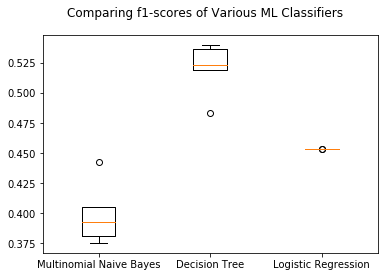

In [34]:
# compare algorithms' f1-score visually via boxplot distributions
fig = plt.figure()
fig.suptitle("Comparing f1-scores of Various ML Classifiers")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

These scores are not bad in comparison to our prior baseline probability of 0.17. Let's use the tree model! It's explainable, meets our assumptions, and has the highest/consistent f1-score.

In [19]:
# create basic tree model
model = tree.DecisionTreeClassifier(criterion = "gini")

In [20]:
# split data into 80/20 to verify model selection
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_me, sampled_training['click'], 
                                                    random_state = 0, test_size = 0.2)

In [21]:
# fit model on training data
model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
# predict if ad will be clicked or not
y_pred = model.predict(x_test)

In [23]:
# measure precision and f1 score to ensure satisfiable
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87    139923
           1       0.37      0.34      0.35     28778

   micro avg       0.79      0.79      0.79    168701
   macro avg       0.62      0.61      0.61    168701
weighted avg       0.78      0.79      0.79    168701



These values look good, especially the micro averages (this value is important since it takes into account the imbalance of classes)! Let's use our tree model on our real testing dataset.

# 5. Predicting probability of ad clicked
Goal is to calculate the probability that an ad will be clicked using our chosen ML classifier (decision tree).

In [24]:
# new dataframe to store id and probability score
prob_of_ad = pd.DataFrame(columns = ['id', 'prob_of_click'])
prob_of_ad['id'] = sampled_test['id']

In [25]:
# remove id since it's not a feature
sampled_test = sampled_test.drop('id', axis = 1)

In [26]:
# fit model and store probability of ad being clicked on testing data into list
prob = []
for row in sampled_test.itertuples():
    #print(model.predict_proba(sampled_test)[row.Index][1]) # to check values since predict_proba is a very slow function
    prob.append(model.predict_proba(sampled_test)[row.Index][1])

In [27]:
# append list to dataframe
prob_of_ad['prob_of_click'] = pd.Series(prob).values

In [28]:
# verify that algorithm is somewhat not non-sensical (should be near 0.17)
prob_of_ad['prob_of_click'].mean()

0.27577469672378135

Wow, our average probability of an ad getting clicked on is 0.236! That's not bad at all, since only 0.17 of ads are clicked on to begin with.

In [29]:
# write dataframe to csv file
prob_of_ad.to_csv("predictions.csv") 

We see that the probability values are categorized (0, 0.333, 0.5, 0.666, 1, etc), 
which makes sense, given our decision tree implementation.